# Emotion Detection

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator #for understanding of image
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

In [22]:
print(tf.__version__)

2.15.0


**Exploring Dataset**

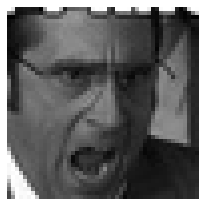

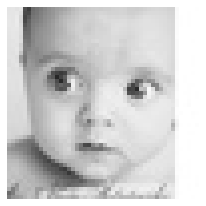

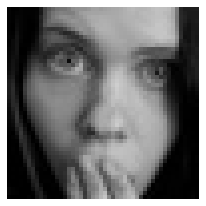

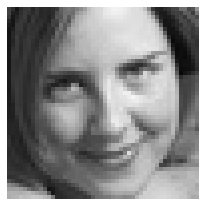

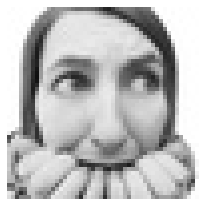

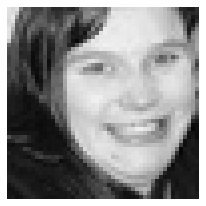

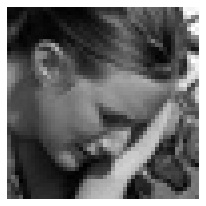

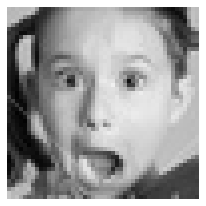

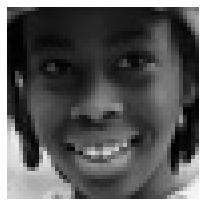

In [23]:
images = glob("train/**/**")
for i in range(1,10):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(3,3,i)
    img = cv2.imread(image)
    plt.imshow(img)
    plt.axis("off")

**Preparing Data**

In [24]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
training_generator = datagen_train.flow_from_directory("train/",
                                                      target_size = (img_size,img_size),
                                                      batch_size = batch_size,
                                                      color_mode = "grayscale",
                                                      class_mode = "categorical",
                                                      shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory("test/",
                                                        target_size = (img_size,img_size),
                                                        color_mode = "grayscale",
                                                        batch_size = batch_size,
                                                        class_mode = "categorical",
                                                        shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [25]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x) #activation function
    x = MaxPooling2D(pool_size=(2,2))(x) #reduce dimensions
    x = Dropout(0.25)(x) #overcome overfitting
    return x


In [26]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [27]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(conv_1, 64, (5,5))
    conv_3 = Convolution(conv_2, 128, (3,3))
    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(7, activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    model.compile(loss = ["categorical_crossentropy"], optimizer = "adam", metrics = ["accuracy"])
    
    return model

In [28]:
model = model_fer((48,48,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

**Initializing the model**

In [29]:
epochs = 15
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy", save_weights_only = True, mode = "max", verbose = 1)
callbacks = [checkpoint]

# Training the Model

In [30]:
history = model.fit(
x = training_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6614 - accuracy: 0.3690
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 162s 353ms/step - loss: 1.6614 - accuracy: 0.3690 - val_loss: 1.4828 - val_accuracy: 0.4265
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3763 - accuracy: 0.4747
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 142s 317ms/step - loss: 1.3763 - accuracy: 0.4747 - val_loss: 1.3115 - val_accuracy: 0.4993
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2614 - accuracy: 0.5194
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 183s 409ms/step - loss: 1.2614 - accuracy: 0.5194 - val_loss: 1.3346 - val_accuracy: 0.4847
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1918 - accuracy: 0.5527
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

**Model Evaluation**

In [31]:
model.evaluate(validation_generator)

113/113 [==============================] - 12s 104ms/step - loss: 1.1797 - accuracy: 0.5605


[1.179659366607666, 0.5604625344276428]

**Plotting Loss**

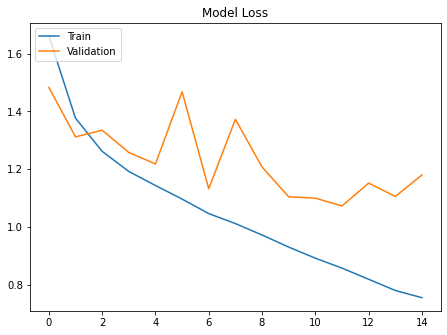

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

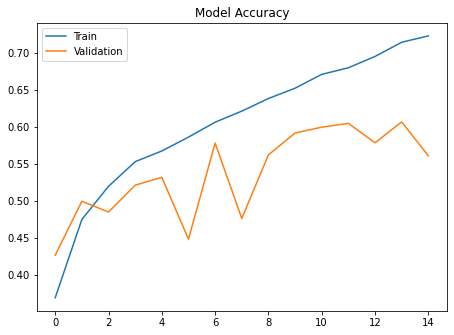

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

**Saving Model**

In [34]:
model_json = model.to_json()
with open('model_a.json',"w") as json_file:
    json_file.write(model_json)